In [40]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv('vgsales.csv')

# Drop rows with missing values
data.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ['Platform', 'Genre', 'Publisher']:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Convert target to binary classification problem
threshold = data['Global_Sales'].median()
data['Global_Sales_Binary'] = (data['Global_Sales'] > threshold).astype(int)

# Split data into features (X) and target (y)
X = data[['Platform', 'Genre', 'Publisher', 'Year']]
y = data['Global_Sales_Binary']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
class GaussianProcess:
    def __init__(self, kernel='RBF', length_scale=1.0, noise=1e-6):
        self.kernel = kernel
        self.length_scale = length_scale
        self.noise = noise
        self.is_fitted = False

    def rbf_kernel(self, X1, X2):
        """Radial Basis Function (RBF) Kernel"""
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return np.exp(-0.5 / self.length_scale**2 * sqdist)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        self.is_fitted = True

    def predict(self, X):
        if not self.is_fitted:
            raise RuntimeError("You must train the model before making predictions")
        K_s = self.rbf_kernel(self.X_train, X)
        K_ss = self.rbf_kernel(X, X) + self.noise * np.eye(len(X))
        mu = K_s.T.dot(self.K_inv).dot(self.y_train)
        cov = K_ss - K_s.T.dot(self.K_inv).dot(K_s)
        return mu, np.diag(cov)

In [42]:
def expected_improvement(X, X_sample, Y_sample, model, xi=0.01):
    mu, sigma = model.predict(X)
    mu_sample = model.predict(X_sample)[0]
    
    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


In [43]:
def propose_location(acquisition, X_sample, Y_sample, model, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, model)
    
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
            
    return min_x.reshape(-1, 1)

In [44]:
def bayesian_optimization(n_iter, initial_samples, bounds):
    X_sample = []
    y_sample = []
    
    for params in initial_samples:
        X_sample.append([params['max_depth'], params['n_estimators'], params['min_samples_split']])
        y_sample.append(objective_function(params))
    
    X_sample = np.array(X_sample)
    y_sample = np.array(y_sample)
    
    model = GaussianProcess()

    for i in range(n_iter):
        model.fit(X_sample, y_sample)
        
        X_next = propose_location(expected_improvement, X_sample, y_sample, model, bounds)
        y_next = objective_function({'max_depth': X_next[0][0], 'n_estimators': X_next[1][0], 'min_samples_split': X_next[2][0]})
        
        X_sample = np.vstack((X_sample, X_next.T))
        y_sample = np.append(y_sample, y_next)
    
    return X_sample, y_sample


In [46]:
# Define search space (hyperparameter bounds)
bounds = np.array([
    [1, 20],  # max_depth
    [50, 200],  # n_estimators
    [2, 20]  # min_samples_split
])

# Initial random samples
np.random.seed(42)
initial_samples = [
    {'max_depth': np.random.uniform(1, 20),
     'n_estimators': np.random.uniform(50, 200),
     'min_samples_split': np.random.uniform(2, 20)}
    for _ in range(5)
]

In [47]:
# Define objective function (to maximize ROC AUC)
def objective_function(params):
    max_depth = int(params['max_depth'])
    n_estimators = int(params['n_estimators'])
    min_samples_split = int(params['min_samples_split'])
    
    # Initialize model with current hyperparameters
    model = RandomForestClassifier(max_depth=max_depth,
                                   n_estimators=n_estimators,
                                   min_samples_split=min_samples_split,
                                   random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Since we want to maximize ROC AUC, return 1 - roc_auc (for minimization)
    return 1 - roc_auc

In [48]:
# Perform Bayesian Optimization to find best hyperparameters
X_sample, y_sample = bayesian_optimization(n_iter=50, initial_samples=initial_samples, bounds=bounds)

# Extract best parameters
best_index = np.argmin(y_sample)
best_params = X_sample[best_index]

best_params_dict = {
    'max_depth': best_params[0],
    'n_estimators': best_params[1],
    'min_samples_split': best_params[2]
}

print("Best Hyperparameters found:")
print(best_params_dict)

# Train final model with best hyperparameters
best_model = RandomForestClassifier(max_depth=int(best_params_dict['max_depth']),
                                    n_estimators=int(best_params_dict['n_estimators']),
                                    min_samples_split=int(best_params_dict['min_samples_split']),
                                    random_state=42)

best_model.fit(X_train, y_train)

# Evaluate final model on test set
y_pred_final_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc_final = roc_auc_score(y_test, y_pred_final_proba)
print(f"Final ROC AUC on Test Set: {roc_auc_final}")


Best Hyperparameters found:
{'max_depth': 16.4987649876311, 'n_estimators': 52.41881217867296, 'min_samples_split': 20.0}
Final ROC AUC on Test Set: 0.7941585959836815


In [55]:
# Random Search for Hyperparameter Optimization
random_params_list = []
random_scores = []
for _ in range(100):
    params = {
        'max_depth': np.random.uniform(1, 20),
        'n_estimators': np.random.uniform(50, 200),
        'min_samples_split': np.random.uniform(2, 20)
    }
    score = objective_function(params)
    random_params_list.append(params)
    random_scores.append(score)

# Convert scores to a numpy array
random_scores = np.array(random_scores)


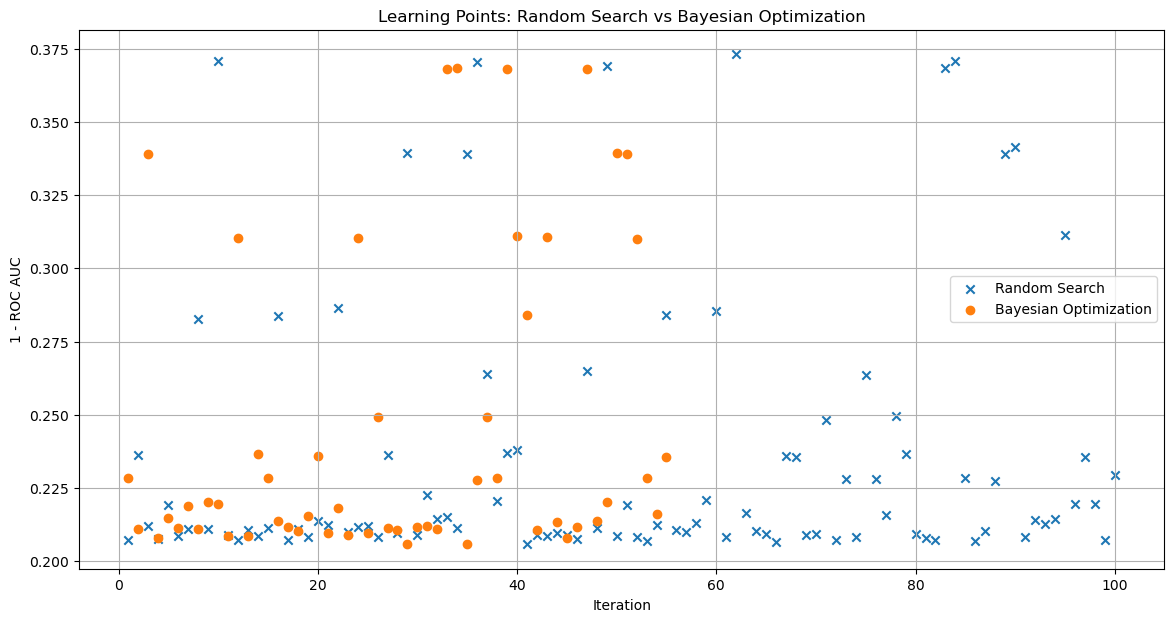

In [57]:
# Plot learning points
plt.figure(figsize=(14, 7))
plt.scatter(range(1, len(random_scores) + 1), random_scores, label='Random Search', marker='x')
plt.scatter(range(1, len(y_sample) + 1), y_sample, label='Bayesian Optimization', marker='o')
plt.xlabel('Iteration')
plt.ylabel('1 - ROC AUC')
plt.legend()
plt.title('Learning Points: Random Search vs Bayesian Optimization')
plt.grid(True)
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

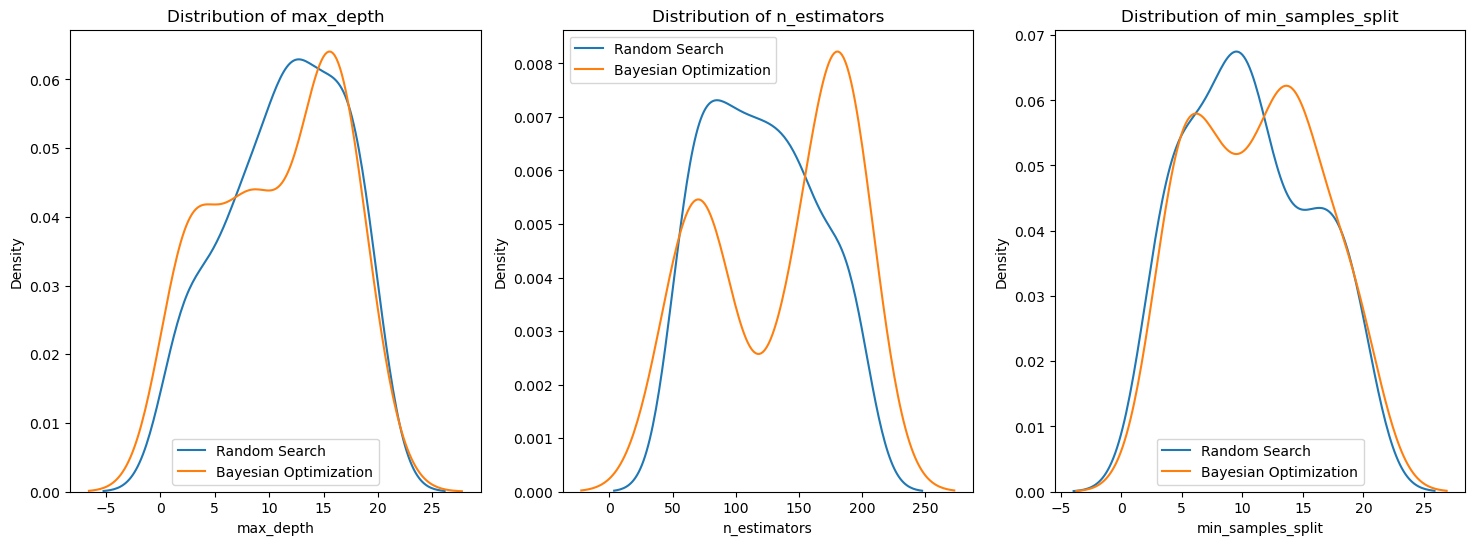

In [70]:
# Plot different graphs for each hyperparameter
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Plot for max_depth
sns.kdeplot([params['max_depth'] for params in random_params_list], label='Random Search', ax=axs[0])
sns.kdeplot(X_sample[:, 0], label='Bayesian Optimization', ax=axs[0])
axs[0].set_xlabel('max_depth')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].set_title('Distribution of max_depth')

# Plot for n_estimators
sns.kdeplot([params['n_estimators'] for params in random_params_list], label='Random Search', ax=axs[1])
sns.kdeplot(X_sample[:, 1], label='Bayesian Optimization', ax=axs[1])
axs[1].set_xlabel('n_estimators')
axs[1].set_ylabel('Density')
axs[1].legend()
axs[1].set_title('Distribution of n_estimators')

# Plot for min_samples_split
sns.kdeplot([params['min_samples_split'] for params in random_params_list], label='Random Search', ax=axs[2])
sns.kdeplot(X_sample[:, 2], label='Bayesian Optimization', ax=axs[2])
axs[2].set_xlabel('min_samples_split')
axs[2].set_ylabel('Density')
axs[2].legend()
axs[2].set_title('Distribution of min_samples_split')

plt.tight_layout